In [1]:
import time
import shap
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

/opt/anaconda3/envs/work/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def backward_regression(X, y, threshold_out=0.05, verbose=True):
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefficients except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {0} with p-value {1}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

def print_accuracy(f, X_test, y_test):
    print('Accuracy = {0}%'.format(100*np.sum(f(X_test) == y_test)/len(y_test)))
    time.sleep(0.5)

shap.initjs()


**Comorb=1, RR_geno=15, RR_mt=5**

In [3]:
df = pd.read_csv('./data/data_geno_15_mt_5_set_0.csv')

genotype = df.iloc[:, 21:-1]
y = df.iloc[:, -1]

X_train, _, y_train, _ = train_test_split(genotype, y, test_size=0.2, random_state=42)
included = backward_regression(X_train, y_train, verbose=False)

In [4]:
genotype_fs = pd.DataFrame(genotype[included])
fs_merged = pd.concat([df.iloc[:, :21], genotype_fs], axis=1)

In [5]:
sc = StandardScaler()
X = sc.fit_transform(fs_merged)

X = pd.DataFrame(X, columns=fs_merged.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_100 = shap.utils.sample(X_train, 100)

**Generalized Linear Models**

In [6]:
# a simple linear logistic model
lr = LogisticRegression(C=1, penalty='l2',max_iter=10000)
lr.fit(X_train, y_train)

def model_proba(x):
    return lr.predict_proba(x)[:,1]
def model_log_odds(x):
    p = lr.predict_log_proba(x)
    return p[:,1] - p[:,0]

In [7]:
svc = LinearSVC(max_iter=10000)
svc.fit(X_train, y_train)

LinearSVC(max_iter=10000)

**Tree Models**

In [8]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

Kernel Explainer

In [9]:
print_accuracy(lr.predict, X_test, y_test)

kernel_explainer = shap.KernelExplainer(lr.predict_proba, X_train_100)
ke_shap_values = kernel_explainer.shap_values(X_test)

Accuracy = 62.75%


Explainers

In [9]:
# Logistic Regression Explainer
explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)

# SVC Explainer
svc_explainer = shap.Explainer(svc, X_train)
svc_shap_values = explainer(X_test)

# Decision Tree Explainer
dt_explainer = shap.TreeExplainer(dt)
dt_shap_values = dt_explainer.shap_values(X_test)

In [10]:
np.shape(shap_values.values)

(400, 36)

In [11]:
np.shape(dt_shap_values[0])

(400, 36)

In [15]:
# Random Forest Explainer
rf_explainer = shap.TreeExplainer(rf)
rf_shap_values = rf_explainer.shap_values(X_test)

# AdaBoost Explainer
ada_explainer = shap.KernelExplainer(ada.predict, X_train_100)
ada_shap_values = ada_explainer.shap_values(X_test)

# GBC Explainer
gbc_explainer = shap.TreeExplainer(gbc)
gbc_shap_values = gbc_explainer.shap_values(X_test)

Exception: Model type not yet supported by TreeExplainer: <class 'method'>

Partial dependence plot

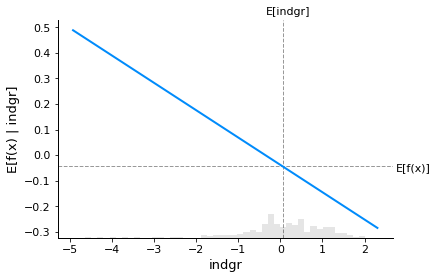

In [8]:
fig, ax = shap.partial_dependence_plot(
    'indgr', model_log_odds, X_test, model_expected_value=True,
    feature_expected_value=True,show=False, ice=False
)

### Plots

**Global bar plot**

Creates a global feature importance plot. Global importance of each feature is the mean absolute value for that feature over all given samples

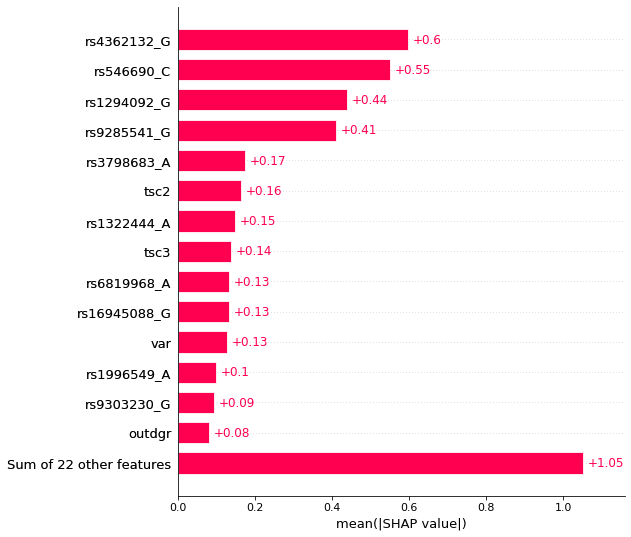

In [9]:
shap.plots.bar(shap_values, max_display=15)

In [ ]:
shap.force_plot(kernel_explainer.expected_value[0], ke_shap_values[0], X_test)

**Waterfall plot**

Displays explanations for individual predictions

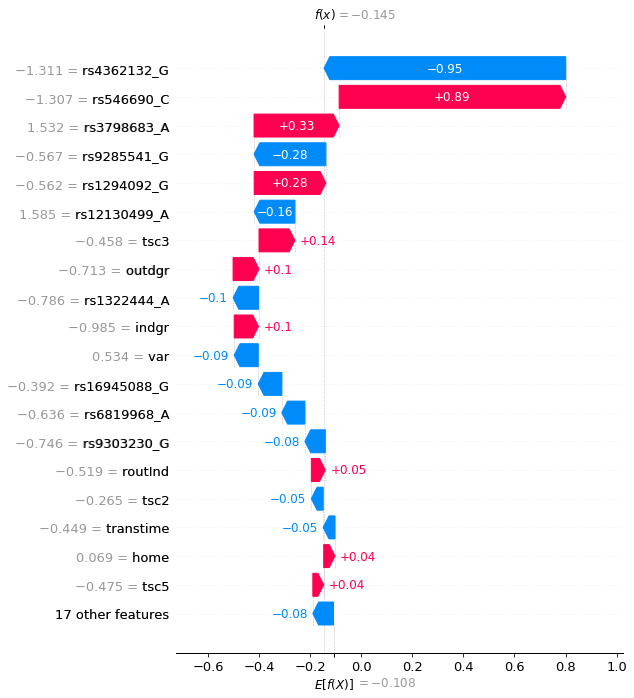

In [29]:
sample_ind = 0 # display explanation for the first prediction
shap.plots.waterfall(shap_values[0], max_display=20)

**Beeswarm plot**

Similar to a global bar plot, but is shows density, and the value of individual explanations

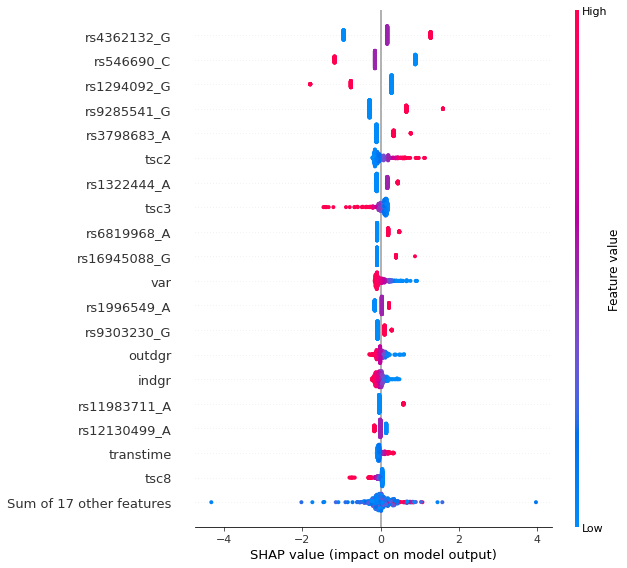

In [12]:
shap.plots.beeswarm(shap_values, max_display=20)
# , color=plt.get_cmap('CMRmap')

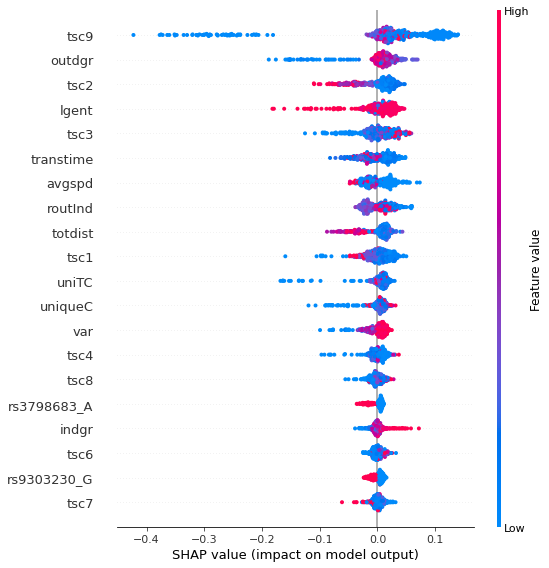

In [41]:
shap.summary_plot(ada_shap_values[0], X_test)

**Heatmap**

Creates a plot with the instances on the x-axis, the model inputs on the y-axis, and the SHAP values encoded on a color scale

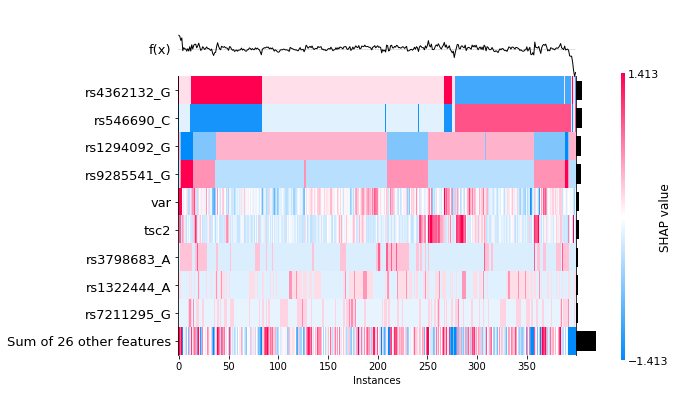

In [ ]:
shap.plots.heatmap(shap_values)

**Force plot**

In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance


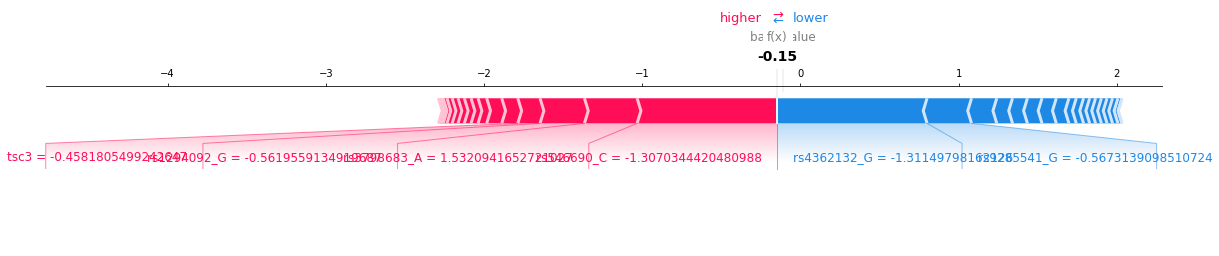

In [42]:
shap.force_plot(shap_values[0,:], X_test.iloc[0,:], matplotlib=True) # force plot for the first instance
# plt.savefig()

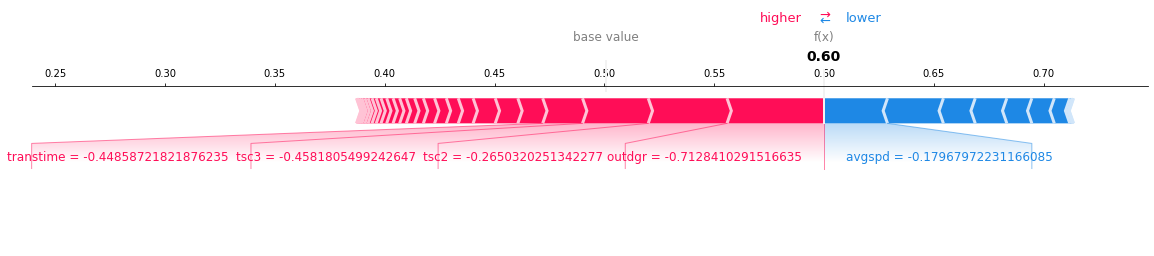

In [43]:
shap.force_plot(ada_explainer.expected_value[0], ada_shap_values[0][0,:], X_test.iloc[0,:], matplotlib=True) # force plot for the first instance

## Aggregate SHAP values processing

In [16]:
import json
import plotly.express as px

In [17]:
with open('agg_shap_values_geno_10_mt_5.json', 'r') as json_file:
    json_dict = json.load(json_file)

df_test = pd.DataFrame(json_dict['logit'], columns=json_dict['df_cols'])

In [18]:
df_test

,var,avgspd,ent,lgent,home,transtime,totdist,routInd,indgr,outdgr,...,rs6551609_A,rs1322444_A,rs1294092_G,rs3798683_A,rs17770427_A,rs2459067_G,rs546690_C,rs10902363_C,rs4362132_G,rs16945088_G
0,0.061582,0.009748,-0.011726,-0.006453,0.011321,0.033579,0.424622,-0.006820,-0.013227,-0.017975,...,-0.084430,0.035660,-0.029052,0.057829,-0.056060,-0.020342,-0.193991,-0.094388,0.286698,-0.039749
1,0.004665,-0.009017,-0.023391,-0.007198,0.011321,0.145819,0.038065,0.001916,-0.041749,-0.043442,...,0.047967,0.089779,-0.030851,0.172734,0.329114,-0.030909,-0.209357,-0.028720,0.235892,0.044648
2,-0.040563,0.002087,-0.041566,-0.009363,0.011321,-0.031086,0.000253,-0.040833,0.005490,0.022094,...,0.068222,-0.057367,0.021705,0.054185,-0.056060,-0.020342,-0.049509,-0.151179,0.188902,-0.039749
3,0.133957,0.061476,0.001306,0.020835,0.011321,-0.051386,-0.020584,-0.015204,0.055513,-0.006404,...,0.011586,0.042505,-0.090651,0.387151,-0.056060,-0.020342,0.181490,0.079820,-0.274579,0.064327
4,0.014695,-0.014366,-0.001635,-0.006142,0.011321,-0.050196,-0.015472,0.002502,0.053846,-0.074375,...,-0.040997,0.028814,0.050929,-0.126986,-0.056060,-0.020342,-0.165409,-0.065806,0.237316,-0.039749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.037306,-0.000828,0.003651,-0.008483,0.011321,0.016730,0.013064,-0.009182,0.036380,-0.004768,...,0.091049,-0.015671,0.050929,-0.126986,-0.056060,0.116507,-0.030413,-0.055576,0.073093,0.006641
396,-0.050850,-0.016079,0.002830,0.064979,0.011321,-0.039992,0.001535,0.020264,0.046353,-0.006142,...,-0.027794,-0.049980,-0.038095,0.221155,0.043418,-0.020342,0.061861,0.003922,-0.059551,-0.039749
397,-0.036769,-0.015646,0.005113,-0.007442,0.011321,0.004501,-0.015116,-0.009550,0.014109,-0.027426,...,-0.031496,-0.005494,0.041886,-0.126986,-0.056060,-0.020342,0.003916,-0.054023,0.062021,0.064327
398,-0.008461,0.031674,-0.008197,0.009511,0.011321,0.040009,-0.009394,-0.010463,0.044725,-0.011375,...,0.034414,0.225045,-0.130442,0.258857,0.118655,-0.020342,-0.228320,-0.095941,0.297770,0.115800
